In [1]:
import os

import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action="ignore")

import matplotlib.pyplot as plt
plt.rcdefaults()
from matplotlib.gridspec import GridSpec
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

import utils

# Config
sns.set_context('notebook', font_scale=1.3)

## Functions

In [2]:
def plot_user_traj(
    data,
    pat_id,
    var,
    time_col="days_since_first_session",
    var_error=None,
    hue_query_fit=None,
    hue_names_fit=None,
    hue_query_plot=None,
    hue_names_plot=None,
    plot_all_efforts=False,
    ax=None,
    title=None,
    figsize=(5, 3),
    do_legend=False,
    legend_loc=(0.5, 0.5),
    fs=12,
    ylabel=None,
    xlabel=None,
    fill_between=True,
    plot_regression_line=True,
    extend_regression=False,
    alpha=[0.9, 0.9],  # [0.7, 0.85],
    marker=["o", "+"],
    size=[50, 140],
    color_1="blue",
    color_2="green",
    color_3="red",
    color_4="red",
    alpha_lr=1,
    **kwargs,
):
    """
    Plot user trajectory for a specific variable.

    Parameters:
    - data: DataFrame containing the data.
    - pat_id: Patient ID.
    - var: Variable to plot.
    - var_error: Error variable (optional).
    - hue_query: Query for hue levels (optional).
    - hue_names: Names for hue levels (optional).
    - plot_all_efforts: Whether to plot all efforts (optional).
    - time_col: time unit column to use (days, months, years).
    - ax: Axes object to plot on (optional).
    - title: Title of the plot (optional).
    - figsize: Figure size (optional).
    - do_legend: Whether to show the legend (optional).
    - fs: Font size (optional).
    - **kwargs: Additional keyword arguments for plotting.

    Returns:
    - DataFrame: DataFrame containing all efforts.
    """
    try:
        if var.startswith("fvc"):
            # esto para las distintas variantes de 'fvc' como percpred o 2019
            df1 = data.query('subject_id == @pat_id and pftType=="fvc"').copy()
        elif var.startswith("vc"):
            df1 = data.query('subject_id == @pat_id and pftType=="svc"').copy()
        else:
            df1 = data.query("subject_id == @pat_id").copy()

        assert time_col in df1.columns, f"ERROR: {time_col} column not found"

        if var == "svc":
            # SVC se llama en realidad vc en el dataframe pero el pftType es svc
            var = "vc"
        # Drop NaNs in the variable column and corresponding dates
        df1 = df1.dropna(subset=[var, time_col])
    except KeyError:
        print(f"Patient with no {var.upper()}")
        return

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=figsize)

    # Main curve
    if hue_query_plot is not None:
        q1_plot, q2_plot = hue_query_plot
        if q1_plot is None and q2_plot is not None:
            df_plot = df1.query(f"{q2_plot}")
        elif q1_plot is not None and q2_plot is None:
            df_plot = df1.query(f"{q1_plot}")
        else:
            df_plot = df1.copy()
    else:
        df_plot = df1.copy()

    if var_error is not None:
        ax.fill_between(
            df_plot[time_col].values,
            df_plot[var].values - df_plot[var_error].values,
            df_plot[var].values + df_plot[var_error].values,
            color="gray",
            alpha=0.2,
        )

    if not plot_all_efforts:

        if hue_query_fit is None:
            l1_fit = hue_names_fit
            x1_fit = df1[time_col].values
            y1_fit = df1[var].values
        else:
            q1_fit, _ = hue_query_fit
            x1_fit = df1.query(q1_fit)[time_col].values
            y1_fit = df1.query(q1_fit)[var].values

        if hue_query_plot is None:
            l1_plot = hue_names_plot
            x1_plot = df1[time_col].values
            y1_plot = df1[var].values
        else:
            q1_plot, q2_plot = hue_query_plot
            l1_plot, l2_plot = hue_names_plot
            x1_plot = df1.query(q1_plot)[time_col].values
            y1_plot = df1.query(q1_plot)[var].values
            if q2_plot is not None:
                x2_plot = df1.query(q2_plot)[time_col].values
                y2_plot = df1.query(q2_plot)[var].values

        # Plot good quality points
        if kwargs.get("facecolor_white", False):
            ax.scatter(
                x1_plot,
                y1_plot,
                color=color_2,
                marker=marker[0],
                alpha=alpha[0],
                facecolors="none",
                label=l1_plot,
                s=size[0],
            )
        else:
            ax.scatter(
                x1_plot,
                y1_plot,
                color=color_2,
                marker=marker[0],
                alpha=alpha[0],
                label=l1_plot,
                s=size[0],
            )

        # Regression Line
        if len(x1_fit) < 3 or len(y1_fit) < 3:
            p_value = np.nan
        else:
            (
                y_pred,
                lower_bound,
                upper_bound,
                p_value,
                slope,
                _,
                intercept,
                _,
            ) = utils.fit_regression(x1_fit, y1_fit, output_all=True)
            if extend_regression:
                # Extend backwards
                x1_fit = np.append(x1_fit, 0)
                y_pred = np.append(y_pred, intercept)

                # Extend forward
                x1_fit = np.append(x1_fit, 15)
                y_pred = np.append(y_pred, 15 * slope + intercept)

            if plot_regression_line:
                ax.plot(
                    x1_fit,
                    y_pred,
                    color=color_4,
                    alpha=alpha_lr,
                    linewidth=2,
                    label=None,
                )
                if fill_between:
                    ax.fill_between(
                        x1_fit, lower_bound, upper_bound, color="lightgrey", alpha=0.2
                    )

        # Plot bad quality points
        if hue_query_plot is not None:
            if q2_plot is not None:
                ax.scatter(
                    x2_plot,
                    y2_plot,
                    color=color_3,
                    marker=marker[-1],
                    alpha=alpha[-1],
                    # facecolors="none",
                    facecolors="white",
                    label=l2_plot,
                    s=size[-1],
                )

        if do_legend:
            ax.legend(loc=(legend_loc))

    ax.set_xlabel(
        xlabel,
        fontdict={"fontsize": fs},
    )
    
    ax.set_yticks([0, 50, 100, 150])
    ax.set_yticklabels([0, 50, 100, 150])
    
    if ylabel is None:
        ylabel = var.upper()
    ax.set_ylabel(ylabel, fontdict={"fontsize": fs})
    if time_col == "date_only":
        ax.tick_params(axis="x", rotation=45)
    ax.tick_params(axis="both", which="major", labelsize=fs)
    ax.tick_params(axis="both", which="minor", labelsize=fs)

    if title is not None:
        ax.set_title(title, fontdict={"fontsize": fs})
    else:
        ax.set_title(f"subject_id: {pat_id[:8]}", fontdict={"fontsize": fs})
    ax.grid(True)

    if ax is None:
        plt.show()
    if do_legend:
        ax.legend(loc=(legend_loc))


In [3]:
def plot_figure_supp2_supp4(
    data: pd.DataFrame,
    pat_list: list,
    data_dict: list,
    time_col="days_since_first_session",
    slopes_intercepts: pd.DataFrame = None, # el df con los slopes e intercepts para cada cond 
    **kwargs,
):
    # FIXED VARS
    figsize=(16, 5)
    ylim = (-0.0, 150)
    xlim = (0, 16)
    mute_titles= True
    mute_right_ticks= True
    mute_x_ticks= True
    plot_regression_line= True,
    extend_regression= False
    fill_between= False
    fs = 16
    label_y={'fvcPercPred_2019': 'FVC % predicted', 'vcPercPred': 'SVC % predicted'}
    xlabel='Months since first session'
    df = data.copy()
    ################
    n_cols = 6
    n_rows = 2
    
    # Creating the shared subplots (occupying the left half)
    fig = plt.figure(figsize=figsize, layout='constrained')
    gs = GridSpec(ncols=n_cols, nrows=n_rows, figure=fig, width_ratios=[1.5,1.5,1,1,1,1])
    
    # Create the subplots dynamically
    axs = [
            fig.add_subplot(gs[0, 0]), 
            fig.add_subplot(gs[0, 1]),
            fig.add_subplot(gs[1, 0]), 
            fig.add_subplot(gs[1, 1])
    ]
    
    ################
    # 4 trajectories    
    for i, pat in enumerate(pat_list):
        for i2, value in enumerate(data_dict):
            key = value["var_name"]
            list_of_kwargs = [
                "hue_query_fit",
                "hue_names_fit",
                "hue_query_plot",
                "hue_names_plot",
                "alpha",
                "marker",
                "size",
                "color_1",
                "color_2",
                "color_3",
                "color_4",
                "alpha_lr",
                "facecolor_white",
            ]
            for l in list_of_kwargs:
                if l in value.keys():
                    kwargs.update({l: value[l]})
            if i2 > 0:
                # Quitar ticks para el segundo eje
                axs[i] = axs[i].twinx()
                if mute_right_ticks:
                    axs[i].set_yticks([])
            
            a = plot_user_traj(
                data,
                pat,
                key,
                time_col=time_col,
                fill_between=fill_between,
                plot_regression_line=plot_regression_line,
                extend_regression=extend_regression,
                ax=axs[i],
                **kwargs,
            )

            axs[i].set_xticks(range(0,20,4))

            # Clean X labels and ticks
            if xlabel is not None:
                if i in [2, 3]:
                    axs[i].set_xlabel(xlabel)
                else:
                    axs[i].tick_params(labelbottom=False) 
            if mute_x_ticks:
                if i < len(pat_list) - 5:
                    axs[i].set_xticklabels("")
                    axs[i].set_xlabel("")

            # Clean Y labels and ticks
            if i2 > 0:
                if (i + 1) % n_cols != 0:
                    axs[i].set_ylabel("")
                else:
                    try:
                        axs[i].set_ylabel(label_y[key])
                    except KeyError:
                        axs[i].set_ylabel(key)
            else:
                if i in [1, 3]:                
                    axs[i].tick_params(labelleft=False) 
                    axs[i].set_ylabel("")
                else:
                    try:
                        axs[i].set_ylabel(label_y[key])
                    except KeyError:
                        axs[i].set_ylabel(key)

            if mute_titles:
                axs[i].set_title("")

            # set xlims y ylims
            if ylim is not None:
                if isinstance(ylim, list):
                    axs[i].set_ylim(ylim[i2])
                else:
                    axs[i].set_ylim(ylim)
            if xlim is not None:
                axs[i].set_xlim(xlim)
                
            axs[i].set_xlabel('')
            axs[i].set_ylabel('')
            
        # add patient id
        print(pat)
        pat = df[df['subject_id'] == pat]['subject_order'].values
        print(pat[0])
        axs[i].text(0.05, 0.05, pat[0], fontsize=14, transform=axs[i].transAxes, ha='left', va='bottom')
        
    fig.text(.22, -.025, kwargs.get('xlabel', 'Months since enrollment'), ha='center', va='center', fontsize=20)
    fig.text(-.02, 0.5, 'SVC % predicted', ha='center', va='center', rotation='vertical', fontsize=20)
    
    #######################
    # Slopes
    single_ax = fig.add_subplot(gs[:, 2:4])
    col1 = 'slope_vcPercPred_proctored'
    col2 = 'slope_vcPercPred_unproctored'
        
    # Pasar a meses
    aux = slopes_intercepts[[col1, col2]].copy()
    # corr, p_val = pearsonr(aux[col1], aux[col2])
    corr, p_val = spearmanr(aux[col1], aux[col2])
    corr, p_val = round(corr,3), round(p_val,3)
    print(f'Correlation between slopes: {corr} (p-val: {p_val})')
        
    single_ax.scatter(aux[col1], aux[col2], edgecolor='k', alpha=0.7, color='grey', cmap='viridis')
    single_ax.set_xlabel(f'Slope SVC % predicted / mo (proc)', fontsize=14)
    single_ax.set_ylabel(f'Slope SVC % predicted / mo (non-proc)', fontsize=14)
    
    # adjust the limits with data simetrically and a margin of 5 percent
    min_val = aux.min().min()
    max_val = aux.max().max()
    margin = 0.05
    min_val = min_val - abs(min_val * margin)
    max_val = max_val + abs(max_val * margin)
    lim = max(abs(min_val), abs(max_val))
    lim = 10.5
    single_ax.set_xlim(-lim-1, lim+1)    
    single_ax.set_ylim(-lim-1, lim+1)
    single_ax.set_xticks([-10,-5,0,5,10])
    single_ax.set_yticks([-10,-5,0,5,10])
    
    single_ax.plot([-lim, lim], [-lim, lim], color='grey', linestyle='--', linewidth=2)
    single_ax.grid(True)
    
    #######################
    # Intercepts
    single_ax_2 = fig.add_subplot(gs[:, 4:6])
    col1 = 'intercept_vcPercPred_proctored'
    col2 = 'intercept_vcPercPred_unproctored'
    
    aux = slopes_intercepts[[col1, col2]].copy()
    # corr, p_val = pearsonr(aux[col1], aux[col2])
    corr, p_val = spearmanr(aux[col1], aux[col2])
    corr, p_val = round(corr,3), round(p_val,3)
    print(f'Correlation between intercepts: {corr} (p-val: {p_val})')
        
    single_ax_2.scatter(aux[col1], aux[col2], edgecolor='k', alpha=0.7, color='grey', cmap='viridis')
    single_ax_2.set_xlabel('Intercept SVC % predicted / mo (proc)', fontsize=14)
    single_ax_2.set_ylabel('Intercept SVC % predicted / mo (non-proc)', fontsize=14)

    # adjust the limits with data simetrically and a margin of 5 percent
    min_val = aux.min().min()
    max_val = aux.max().max()
    margin = 0.05
    min_val = min_val - abs(min_val * margin)
    max_val = max_val + abs(max_val * margin)
    min_val = 60
    max_val = 130
        
    # Plot identity line
    single_ax_2.plot([min_val, max_val], [min_val, max_val], color='grey', linestyle='--', linewidth=2)
    single_ax_2.grid(True)
    
    #######################
    # Format 
    # letters with automatic positioning
    axs[0].text(0.00, 1.35, 'a', fontsize=30, transform=axs[0].transAxes, va='top', ha='left')
    single_ax.text(0.00, 1.15, 'b', fontsize=30, transform=single_ax.transAxes, va='top', ha='left')
    single_ax_2.text(.00, 1.15, 'c', fontsize=30, transform=single_ax_2.transAxes, va='top', ha='left')
    
    plt.show()

## Data

In [4]:
PATH = 'data'
FILE = 'data_figsup2_sup4.csv'
df_data = pd.read_csv(os.path.join(PATH,FILE))

time_col = "months_since_first_session"

# Keep only FVC
print(">>> Keeping only SVC and subjects with at least one proctored and one non-proctored")
df_data = df_data.query('pftType=="svc"')

# Keep only those with at least one of each proctored and non-proctored
subs = df_data.groupby('subject_id').apply(lambda s: s.is_proctored.nunique()==2)
subs = subs[subs].index
df_data = df_data.query('subject_id in @subs')

print(f'N subjects: {df_data.subject_id.nunique()}')
print(f"N proctored sessions: {df_data.query('is_proctored==True').session_id.nunique()}")
print(f"N non-proctored sessions: {df_data.query('is_proctored==False').session_id.nunique()}")
print(f"N sessions: {df_data.session_id.nunique()}")

# Keep ionly subjects with at least 4 proctored sessions
print(">>> Keeping only subjects with at least 4 proctored and 4 non-proctored sessions")
subs_proc = df_data.query('is_proctored==True').groupby('subject_id').session_id.nunique()
subs_nonproc = df_data.query('is_proctored==False').groupby('subject_id').session_id.nunique()
subs = subs_proc[subs_proc>=4].index.intersection(subs_nonproc[subs_nonproc>=4].index)
df_data = df_data.query('subject_id in @subs')

print(f'N subjects: {df_data.subject_id.nunique()}')
print(f"N proctored sessions: {df_data.query('is_proctored==True').session_id.nunique()}")
print(f"N non-proctored sessions: {df_data.query('is_proctored==False').session_id.nunique()}")
print(f"N sessions: {df_data.session_id.nunique()}")


>>> Keeping only SVC and subjects with at least one proctored and one non-proctored
N subjects: 22
N proctored sessions: 315
N non-proctored sessions: 186
N sessions: 501
>>> Keeping only subjects with at least 4 proctored and 4 non-proctored sessions
N subjects: 13
N proctored sessions: 141
N non-proctored sessions: 145
N sessions: 286


In [5]:
# Calcular el df con los slopes e intercepts individuales
df_intercept_slopes = pd.DataFrame()
var = 'vcPercPred'
# tcol = 'days_since_first_session'
print(time_col)
tcol = time_col

for subj in df_data.subject_id.unique():
    df_proc = df_data.query('subject_id==@subj').query('is_proctored==True')
    df_nonproc = df_data.query('subject_id==@subj').query('is_proctored==False')
    
    # Proctored fit ols linear regression
    x = df_proc[tcol]
    y = df_proc[var]
    model = OLS(y, sm.add_constant(x)).fit()
    slope_proc, intercept_proc = model.params[tcol], model.params['const']
    
    # Non-proctored fit ols linear regression
    x = df_nonproc[tcol]
    y = df_nonproc[var]
    model = OLS(y, sm.add_constant(x)).fit()
    slope_nonproc, intercept_nonproc = model.params[tcol], model.params['const']
    
    df_intercept_slopes = df_intercept_slopes.append({
        'subject_id': subj,
        'intercept_vcPercPred_proctored': intercept_proc,
        'slope_vcPercPred_proctored': slope_proc,
        'intercept_vcPercPred_unproctored': intercept_nonproc,
        'slope_vcPercPred_unproctored': slope_nonproc
    }, ignore_index=True)

df_intercept_slopes.head(2)

months_since_first_session


,subject_id,intercept_vcPercPred_proctored,slope_vcPercPred_proctored,intercept_vcPercPred_unproctored,slope_vcPercPred_unproctored
0,095b55de-6600-4d17-b8e6-387a7ef9db6f,100.776774,-5.860323,94.512514,-3.825473
1,1d59047d-2b3a-4c3e-aba0-be593ce142fc,106.909543,-0.585396,107.129254,-0.918024


### Figures

In [6]:
patient_sorted = [
    'b323b082-0ca4-4b58-b899-3e87e41074fb',
    '095b55de-6600-4d17-b8e6-387a7ef9db6f',
    'fc3f4670-6329-4886-868e-81eb8f8f7ba3',
    '9941063b-9b74-4eb0-b24f-b73cb9324ee5',
]

colors = sns.color_palette("colorblind").as_hex()

data_dict_svc = [
    
    {'var_name': 'vcPercPred',
    'hue_query_fit': [
            'is_proctored', None
    ],
    'hue_names_fit':  [None, None],
    'hue_query_plot': [ 
        'is_proctored', None
    ],
    'hue_names_plot': [None, None],
    'alphas': [0.9],
    'marker':['o'],
    'color_1': colors[3],#'#c59434',
    'color_2': colors[3],#'#c59434',
    'color_3': colors[3],#'#c59434',
    'color_4': colors[3],#'#c59434'
    'alpha_lr':1,
    'facecolor_white': False,
    },
    
    {'var_name': 'vcPercPred',
    'hue_query_fit': [
            'not is_proctored', None
    ],
    'hue_names_fit':  [None, None],
    'hue_query_plot': [ 
        'not is_proctored', None
    ],
    'hue_names_plot': [None, None],
    'alpha': [0.9],
    'marker':['o'],
    'color_1': colors[3],#'#f4d4d4',
    'color_2': colors[3],#'#f4d4d4',
    'color_3': colors[3],#'#f4d4d4',
    'color_4': colors[3],#'#f4d4d4',
    'alpha_lr':0.9,
    'facecolor_white': True,
    },
]

b323b082-0ca4-4b58-b899-3e87e41074fb
pALS 5
095b55de-6600-4d17-b8e6-387a7ef9db6f
pALS 31
fc3f4670-6329-4886-868e-81eb8f8f7ba3
pALS 6
9941063b-9b74-4eb0-b24f-b73cb9324ee5
pALS 43
Correlation between slopes: 0.286 (p-val: 0.344)
Correlation between intercepts: 0.846 (p-val: 0.0)


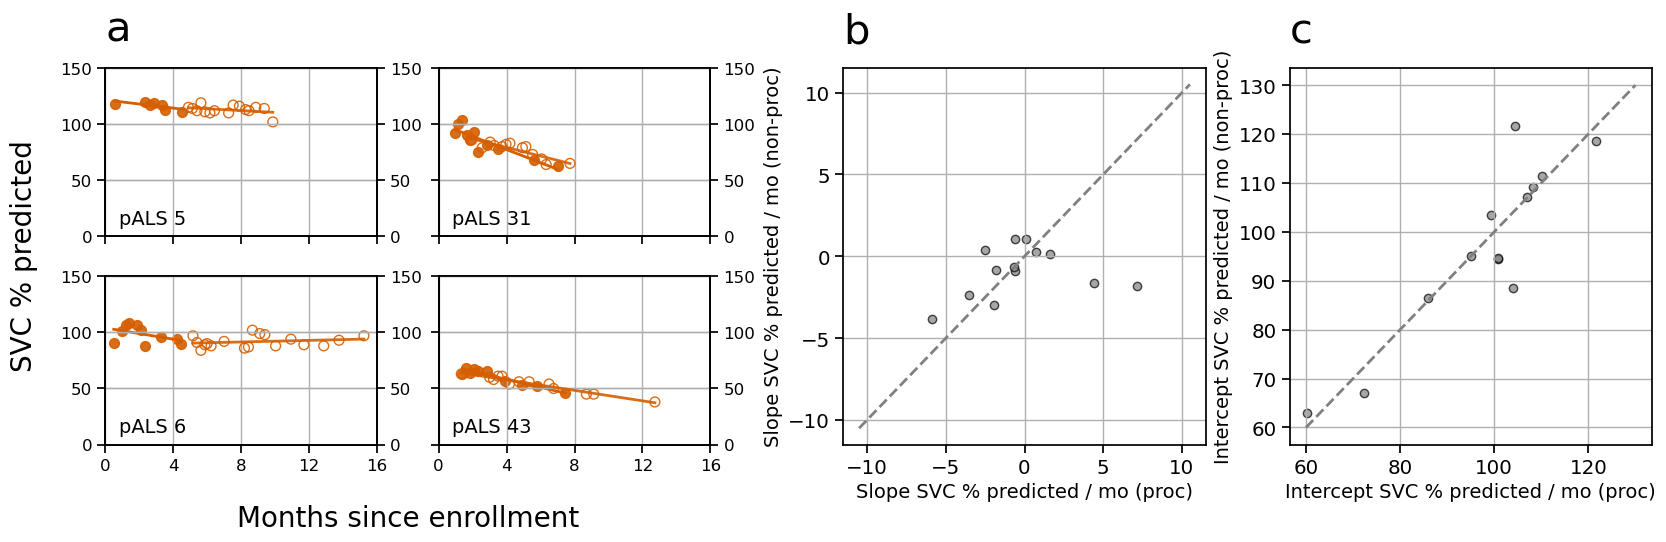

In [7]:
# Figura nueva
time_col = "months_since_first_session"
plot_figure_supp2_supp4(
                    data = df_data, 
                    pat_list = patient_sorted,
                    slopes_intercepts=df_intercept_slopes,
                    data_dict = data_dict_svc,
                    time_col=time_col,
                )

In [8]:
df_intercept_slopes[['slope_vcPercPred_proctored', 'slope_vcPercPred_unproctored']].corr(method='pearson')

,slope_vcPercPred_proctored,slope_vcPercPred_unproctored
slope_vcPercPred_proctored,1.000000,0.233155
slope_vcPercPred_unproctored,0.233155,1.000000
